In [15]:
# 1. Import dependencies and load Dollar Bars data
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

project_root = Path.cwd().parent.parent  # two levels above notebooks/data_process/
bars_path = project_root / "data" / "preprocess_data" / "BTCUSDT_dollar_bars_560k.csv"

df = pd.read_csv(bars_path)

In [ ]:
# 2. Compute log returns

# If there is a timestamp column, convert it to datetime index (support mixed ms/us)
time_col = None
for col in ["close_time", "open_time", "datetime", "timestamp"]:
    if col in df.columns:
        time_col = col
        break

if time_col is not None:
    col_data = df[time_col]
    # Numeric timestamps: may contain both milliseconds (ms, 13 digits) and microseconds (us, 16 digits)
    if np.issubdtype(col_data.dtype, np.number):
        ts = col_data.astype("int64")
        # Use number of digits to distinguish ms / us: <=13 digits -> ms, >13 digits -> us
        ts_len = ts.astype("string").str.len()
        ms_mask = ts_len <= 13
        us_mask = ts_len > 13
        print(f"Time column '{time_col}': {ms_mask.sum()} rows as ms, {us_mask.sum()} rows as us")

        dt = pd.Series(index=ts.index, dtype="datetime64[ns]")
        if ms_mask.any():
            dt.loc[ms_mask] = pd.to_datetime(ts[ms_mask], unit="ms", errors="coerce")
        if us_mask.any():
            dt.loc[us_mask] = pd.to_datetime(ts[us_mask], unit="us", errors="coerce")
        if dt.isna().any():
            print(f"Warning: {dt.isna().sum()} timestamps could not be converted and are set to NaT.")
        df["dt"] = dt
    else:
        # String timestamps: let pandas parse them
        df["dt"] = pd.to_datetime(col_data, errors="coerce")
        if df["dt"].isna().any():
            print(f"Warning: {df['dt'].isna().sum()} timestamps could not be parsed and are set to NaT.")

    df = df.set_index("dt").sort_index()

# Compute log returns: log(p_t / p_{t-1})
df["log_ret"] = np.log(df["close"]).diff()

# Drop the first NaN
returns = df["log_ret"].dropna()

print("Basic statistics of log returns:")
print(returns.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

Time column 'close_time': 410086 rows as ms, 82090 rows as us
Basic statistics of log returns:
count    4.921750e+05
mean     5.082542e-06
std      2.320168e-03
min     -6.720875e-02
1%      -6.205513e-03
5%      -3.367765e-03
50%      2.586311e-07
95%      3.364071e-03
99%      6.192177e-03
max      8.853553e-02
Name: log_ret, dtype: float64


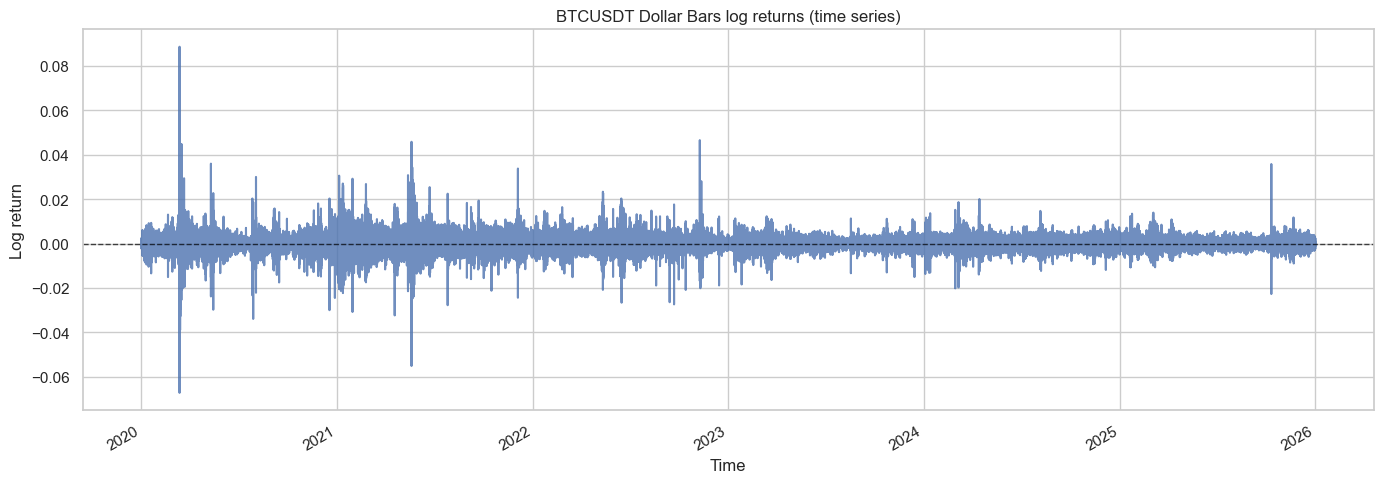

In [5]:
# 3. Time series of log returns
plt.figure(figsize=(14, 5))
returns.plot(alpha=0.8)
plt.title("BTCUSDT Dollar Bars log returns (time series)")
plt.xlabel("Time")
plt.ylabel("Log return")
plt.axhline(0, color="black", linewidth=1, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

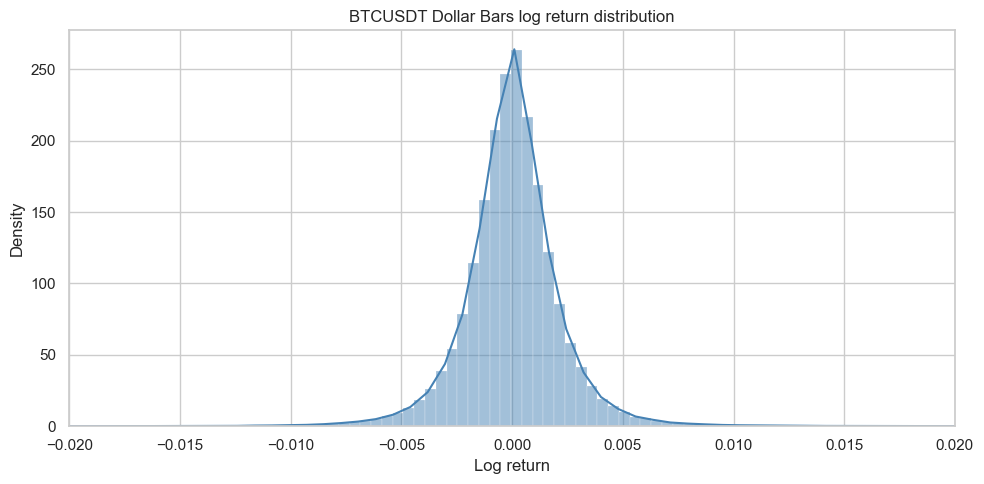

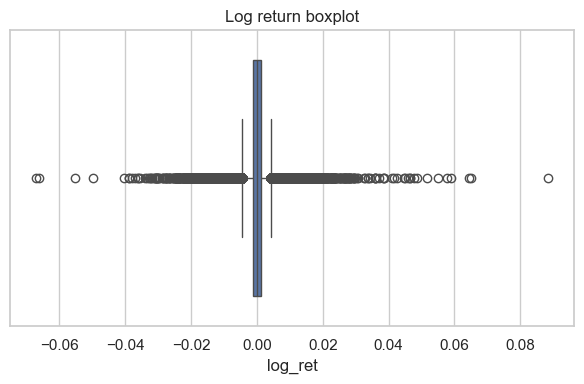

In [14]:
# 4. Distribution of log returns: histogram + KDE
plt.figure(figsize=(10, 5))
sns.histplot(returns, bins=320, kde=True, stat="density", color="steelblue")
plt.title("BTCUSDT Dollar Bars log return distribution")
plt.xlabel("Log return")
plt.ylabel("Density")
plt.xlim(-0.02, 0.02)
plt.tight_layout()
plt.show()

# 5. Boxplot to inspect tails and skewness
plt.figure(figsize=(6, 4))
sns.boxplot(x=returns, orient="h")
plt.title("Log return boxplot")
plt.tight_layout()
plt.show()

Mean: 5.0825418272296216e-06
Standard deviation: 0.0023201675607042323
Skewness: 0.3138125153890032
Kurtosis (Fisher): 29.699840036888375


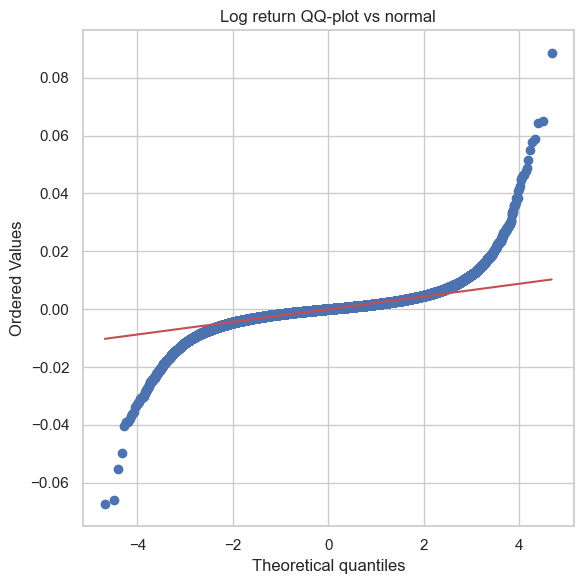

In [7]:
# 6. Simple normality and tail behavior check
from scipy import stats

mean = returns.mean()
std = returns.std()
skew = stats.skew(returns)
kurt = stats.kurtosis(returns, fisher=True)  # Fisher=True -> 0 means normal distribution

print("Mean:", mean)
print("Standard deviation:", std)
print("Skewness:", skew)
print("Kurtosis (Fisher):", kurt)

# QQ plot
fig = plt.figure(figsize=(6, 6))
stats.probplot(returns, dist="norm", plot=plt)
plt.title("Log return QQ-plot vs normal")
plt.tight_layout()
plt.show()